# Multi-Class Sentiment Classification using BERT

In [60]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly as px

## DataSet Analysis

In [61]:
data = pd.read_csv('sample_data/twitter_multi_class_sentiment.csv')
data.head(10)

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger
5,ive been feeling a little burdened lately wasn...,0,sadness
6,ive been taking or milligrams or times recomme...,5,surprise
7,i feel as confused about life as a teenager or...,4,fear
8,i have been with petronas for years i feel tha...,1,joy
9,i feel romantic too,2,love


In [62]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16000 entries, 0 to 15999
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   text        16000 non-null  object
 1   label       16000 non-null  int64 
 2   label_name  16000 non-null  object
dtypes: int64(1), object(2)
memory usage: 375.1+ KB


In [63]:
print("No. of Rows:", data.shape[0])
print("No. of Columns:", data.shape[1])

No. of Rows: 16000
No. of Columns: 3


In [64]:
print(data.columns)

Index(['text', 'label', 'label_name'], dtype='object')


In [65]:
data.isnull().sum()

,0
text,0
label,0
label_name,0


No. of labels:
 label
5     572
2    1304
4    1937
3    2159
0    4666
1    5362
Name: count, dtype: int64


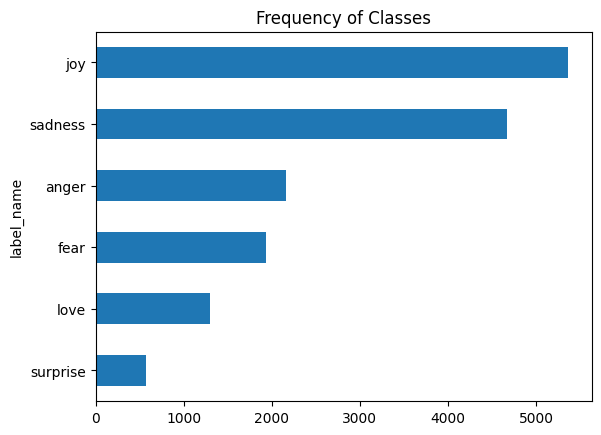

In [66]:
print('No. of labels:\n', data['label'].value_counts(ascending=True))
label_counts = data['label_name'].value_counts(ascending=True)
label_counts.plot.barh()
plt.title("Frequency of Classes")
plt.show()

In [67]:
data['No of Words'] = data['text'].str.split().apply(len)
data.head()

,text,label,label_name,No of Words
0,i didnt feel humiliated,0,sadness,4
1,i can go from feeling so hopeless to so damned...,0,sadness,21
2,im grabbing a minute to post i feel greedy wrong,3,anger,10
3,i am ever feeling nostalgic about the fireplac...,2,love,18
4,i am feeling grouchy,3,anger,4


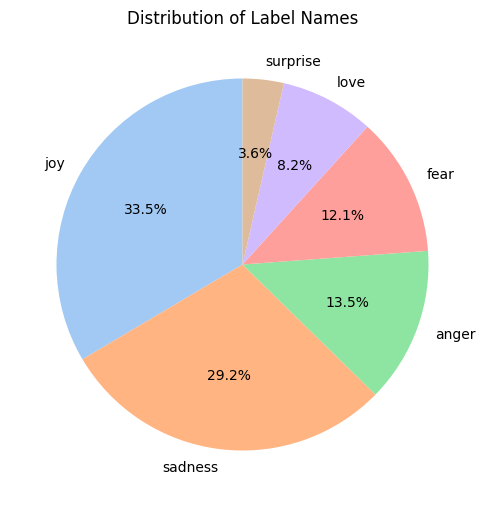

In [68]:
label_counts = data['label_name'].value_counts()

plt.figure(figsize=(6, 15))
plt.pie(
    label_counts,
    labels=label_counts.index,
    autopct='%1.1f%%',
    startangle=90,
    colors=sns.color_palette("pastel")
)
plt.title("Distribution of Label Names")
plt.show()

In [69]:
for i in range(10):
    print("Text:",[i], data['text'].iloc[i])

Text: [0] i didnt feel humiliated
Text: [1] i can go from feeling so hopeless to so damned hopeful just from being around someone who cares and is awake
Text: [2] im grabbing a minute to post i feel greedy wrong
Text: [3] i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Text: [4] i am feeling grouchy
Text: [5] ive been feeling a little burdened lately wasnt sure why that was
Text: [6] ive been taking or milligrams or times recommended amount and ive fallen asleep a lot faster but i also feel like so funny
Text: [7] i feel as confused about life as a teenager or as jaded as a year old man
Text: [8] i have been with petronas for years i feel that petronas has performed well and made a huge profit
Text: [9] i feel romantic too


In [70]:
from transformers import AutoTokenizer

Model = 'bert-base-uncased'
tokenizer = AutoTokenizer.from_pretrained(Model)

#Testing Pretrained Model
text = "I love machine learning!. It is the most emerging field in the market"
encoded_text = tokenizer(text)
print(encoded_text)

{'input_ids': [101, 1045, 2293, 3698, 4083, 999, 1012, 2009, 2003, 1996, 2087, 8361, 2492, 1999, 1996, 3006, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [71]:
len(tokenizer.vocab), tokenizer.vocab_size, tokenizer.model_max_length

(30522, 30522, 512)

## Train Test Split

In [72]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(data, test_size=0.3, stratify=data['label_name'])
test, validation = train_test_split(test, test_size = 1/3, stratify=test['label_name'])
print("Train:", train.shape)
print("Test:", test.shape)
print("Validation:", validation.shape)


Train: (11200, 4)
Test: (3200, 4)
Validation: (1600, 4)


In [74]:
from datasets import Dataset, DatasetDict

dataset = DatasetDict(
    {
    "train": Dataset.from_pandas(train, preserve_index=False),
    "test": Dataset.from_pandas(test, preserve_index=False),
    "validation": Dataset.from_pandas(validation, preserve_index=False)
    }
)
print(dataset)


DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'No of Words'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'No of Words'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'No of Words'],
        num_rows: 1600
    })
})


## Tokenization of Sentiment Data

In [75]:
dataset['train'][0], dataset['train'][1]

({'text': 'i feel unhappy it is no help for me that other persons say that i am happy how much truth there may be in it',
  'label': 0,
  'label_name': 'sadness',
  'No of Words': 25},
 {'text': 'i was feeling brave when i bought it and clearly when i was doing my makeup',
  'label': 1,
  'label_name': 'joy',
  'No of Words': 16})

In [76]:
def tokenize(batch):
    temp = tokenizer(batch['text'], padding=True, truncation=True)
    return temp
print(tokenize(dataset['train'][0]))

{'input_ids': [101, 1045, 2514, 12511, 2009, 2003, 2053, 2393, 2005, 2033, 2008, 2060, 5381, 2360, 2008, 1045, 2572, 3407, 2129, 2172, 3606, 2045, 2089, 2022, 1999, 2009, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}


In [77]:
emotion_encoded = dataset.map(tokenize, batch_size=None, batched=True)
emotion_encoded

Map:   0%|          | 0/11200 [00:00<?, ? examples/s]

Map:   0%|          | 0/3200 [00:00<?, ? examples/s]

Map:   0%|          | 0/1600 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['text', 'label', 'label_name', 'No of Words', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 11200
    })
    test: Dataset({
        features: ['text', 'label', 'label_name', 'No of Words', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3200
    })
    validation: Dataset({
        features: ['text', 'label', 'label_name', 'No of Words', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1600
    })
})

In [78]:
label2id = {x['label_name']:x['label'] for x in dataset['train']}
id2label = {v:k for k,v in label2id.items()}

label2id, id2label

({'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2},
 {0: 'sadness', 1: 'joy', 4: 'fear', 5: 'surprise', 3: 'anger', 2: 'love'})

## Model Building

In [79]:
from transformers import AutoModelForSequenceClassification, AutoConfig, TrainingArguments, Trainer
import torch

In [80]:
#model = AutoModel.from_pretrained(Model)

In [81]:
#model.config

In [82]:
num_labels = len(id2label)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

config = AutoConfig.from_pretrained(Model, label2id=label2id, id2label=id2label)
model = AutoModelForSequenceClassification.from_pretrained(Model, config=config).to(device)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [83]:
batch_size = 64
training_dir = 'bert_base_train_dir'

training_args = TrainingArguments(
    output_dir=training_dir,
    overwrite_output_dir=True,
    num_train_epochs=2,
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    eval_strategy='epoch',
    disable_tqdm=False,
)


In [84]:
import evaluate
import numpy as np


accuracy = evaluate.load("accuracy")
def compute_metrics_evaluate(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=labels)

In [85]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)

    f1 = f1_score(y_true=labels, y_pred=preds, average='weighted')
    acc = accuracy_score(y_true=labels, y_pred=preds)

    return {"accuracy": acc, "f1": f1}

## Build Model Trainer

In [86]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=emotion_encoded['train'],
    eval_dataset=emotion_encoded['validation'],
    compute_metrics=compute_metrics,
    tokenizer = tokenizer
)

print(tokenizer)

BertTokenizerFast(name_or_path='bert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=False, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	100: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	101: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	102: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	103: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)


<ipython-input-86-21209b6fd6b7>:1: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


In [87]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
1,No log,0.436448,0.868750,0.859407
2,No log,0.275951,0.904375,0.904767


TrainOutput(global_step=350, training_loss=0.6895584542410714, metrics={'train_runtime': 337.6752, 'train_samples_per_second': 66.336, 'train_steps_per_second': 1.036, 'total_flos': 1001502421516800.0, 'train_loss': 0.6895584542410714, 'epoch': 2.0})

# Model Evaluation

In [88]:
preds_output = trainer.predict(emotion_encoded['test'])
preds_output.metrics

{'test_loss': 0.28428658843040466,
 'test_accuracy': 0.904375,
 'test_f1': 0.9038531123524638,
 'test_runtime': 12.8351,
 'test_samples_per_second': 249.317,
 'test_steps_per_second': 3.896}

In [89]:
y_pred = np.argmax(preds_output.predictions, axis = 1)
y_true = emotion_encoded['test'][:]['label']
emotion_encoded['test'][0]

{'text': 'i feel pressured to be the perfect happy woman but it s because i have a hard time letting people in past a certain level so it just is easier to default to happy go lucky which i usually am anyway',
 'label': 4,
 'label_name': 'fear',
 'No of Words': 41,
 'input_ids': [101,
  1045,
  2514,
  25227,
  2000,
  2022,
  1996,
  3819,
  3407,
  2450,
  2021,
  2009,
  1055,
  2138,
  1045,
  2031,
  1037,
  2524,
  2051,
  5599,
  2111,
  1999,
  2627,
  1037,
  3056,
  2504,
  2061,
  2009,
  2074,
  2003,
  6082,
  2000,
  12398,
  2000,
  3407,
  2175,
  5341,
  2029,
  1045,
  2788,
  2572,
  4312,
  102,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0],
 'token_type_ids': [0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0,
  0

In [90]:
from sklearn.metrics import classification_report, confusion_matrix
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95       933
           1       0.92      0.91      0.92      1072
           2       0.77      0.72      0.74       261
           3       0.91      0.91      0.91       432
           4       0.90      0.88      0.89       387
           5       0.79      0.83      0.81       115

    accuracy                           0.90      3200
   macro avg       0.87      0.87      0.87      3200
weighted avg       0.90      0.90      0.90      3200



In [91]:
label2id

{'sadness': 0, 'joy': 1, 'fear': 4, 'surprise': 5, 'anger': 3, 'love': 2}

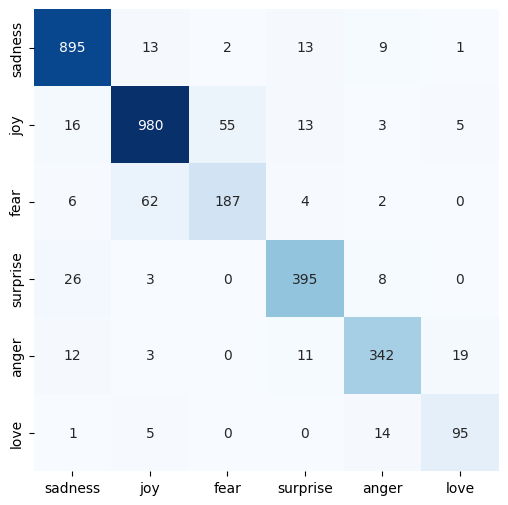

In [92]:
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', vmin=0, cmap='Blues', cbar=False, xticklabels=label2id.keys(), yticklabels=label2id.keys())
plt.show()

# Build Prediction Function and Store Model

In [114]:
def get_prediction(text):
    input_encoded = tokenizer(text, return_tensors='pt').to(device)

    with torch.no_grad():
        output = model(**input_encoded)
        logits = output.logits
        pred = torch.argmax(logits, dim=-1).item()
    return id2label[pred]

text = "I am super happy today. I got it done. Finally!!!!"
get_prediction(text)

'joy'

In [115]:
text = "I am done with you!"
get_prediction(text)


'anger'

In [116]:
trainer.save_model('bert-base-uncased-sentiment-model')

In [117]:
from transformers import pipeline

classifier = pipeline("text-classification", model='bert-base-uncased-sentiment-model')
classifier([text, 'hello', 'how are you?', 'love you', 'I am feeling low'])

Device set to use cuda:0


[{'label': 'anger', 'score': 0.5784160494804382},
 {'label': 'joy', 'score': 0.6600044369697571},
 {'label': 'joy', 'score': 0.8557219505310059},
 {'label': 'love', 'score': 0.7342261075973511},
 {'label': 'sadness', 'score': 0.9678516387939453}]